# [Kelly Criterion](https://en.wikipedia.org/wiki/Kelly_criterion) Research
Reference [LaTeX](https://en.wikibooks.org/wiki/LaTeX/Mathematics)

## Flip coin model - One random variable, binary states
Let's start with the simplest game: flipping a coin with 50/50 chance win or lose, which give you two different rate of return: 300% and -100% (If you win, you triple your investment, if you lose, you lose all). Then what percentage of your money should you use to play the game?

Some notation we used for the following deduction:
- $ p_{win} $: The probability of winning.
- $ p_{lose} = 1 - p_{win} $: The probability of losing.
- $ r_{win} \in (0, +\infty) $: Payout / rate of return when winning.
- $ r_{lose} \in [-1,0) $: Payout / rate of return when losing.
- $ M_n $: Total asset / money after $ n^{th} $ game.
- $ x \in [0, 1] $: Our target investment fraction, which is also the solution of the puzzle.

Let's write the recursive formula of you money before and after $ n^{th} $ game assume we only put $ x $ portion of our money.
- Win: $ M_{n+1} = M_n + M_n r_{win}x = M_n (1 + r_{win} x) $
- Lose: $ M_{n+1} = M_n + M_n r_{lose}x = M_n (1 + r_{lose} x) $

After $ n $ games, we will win $ np_{win} $ times and lose $ np_{lose} $ times. The final result will be:

$ M_n = M_{0} (1 + r_{win} x)^{np_{win}} (1 + r_{lose} x)^{np_{lose}} $

When playing $ \infty $ games, the average return will be:

$ \lim\limits_{n \to \infty} \sqrt[n]{ \frac{M_n}{M_0} } = (1 + r_{win} x)^{p_{win}} (1 + r_{lose} x)^{p_{lose}} $

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Expectation is: 0.3999999999999999


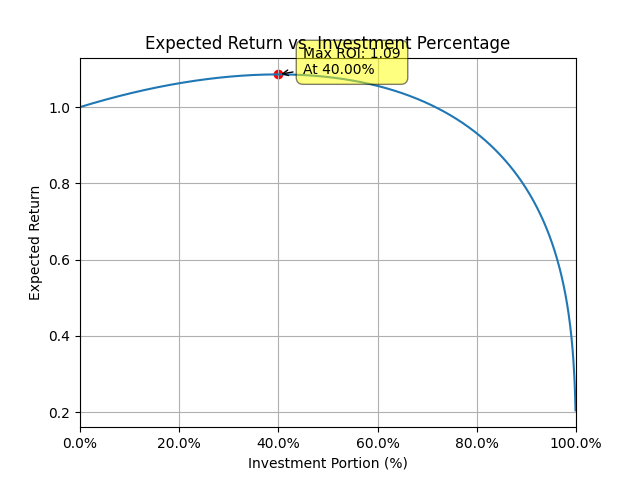

In [92]:
%load_ext autoreload
%autoreload 2

import numpy as np
from plot import draw2dPlot

P_WIN = 0.7
P_LOSE = 1 - P_WIN
R_WIN = 1.00   # Triple the investment.
R_LOSE = -1.00 # Lose all.

investment_fractions = np.arange(0, 1, 0.001)
expected_returns = ((1 + R_WIN * investment_fractions) ** P_WIN) * ((1 + R_LOSE * investment_fractions) ** P_LOSE)  # Average return per game

print("Expectation is:", P_WIN * R_WIN + P_LOSE * R_LOSE)
optimal_investment_fraction = - P_WIN / R_LOSE - P_LOSE / R_WIN
draw2dPlot(investment_fractions, expected_returns, optimal_investment_fraction, np.max(expected_returns))

### Take the Logarithm

We want the left-hand side to be maximum to provide us best rate of return per game, which means we need to let the first order derivative of right-hand side equal to 0.

Take a logarithm to both side will make the calculation much easier:

$ G(x) = \lim\limits_{n \to \infty} \frac{1}{n} \ln{\frac{M_n}{M_0}} = p_{win} \ln{(1 + r_{win} x)} + p_{lsoe} \ln{(1 + r_{lose} x)} $

$ G'(x) = \frac{p_{win} r_{win}}{1 + r_{win} x} + \frac{p_{lose} r_{lose}}{1 + r_{lose} x} = 0 $

$ G''(x) = -\frac{p_{win}r^2_{win}}{(1+r_{win}x)^2} - \frac{p_{lose}r^2_{lose}}{(1+r_{lose}x)^2} \le 0 $

The second derivative is always smaller than zero which shows $ G(x) $ is **concave** hence will have maximum point.

$ G'(0) = p_{win} r_{win} + p_{lose} r_{lose} = E(r) $

$ x = \frac{p_{win} r_{win} + p_{lose} r_{lose}}{- r_{win} r_{lose}} = -\frac{p_{win}}{r_{lose}} - \frac{p_{lose}}{r_{win}} $

Above is the stardard Kelly Criterion.

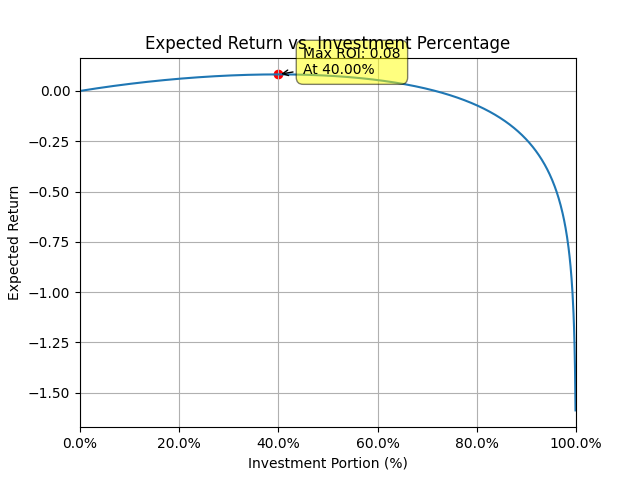

In [93]:
# Draw the same plot in log:
expected_returns = P_WIN * np.log(1 + R_WIN * investment_fractions) + P_LOSE * np.log(1 + R_LOSE * investment_fractions)  # Average log return per game

max_expected_return = np.max(expected_returns)
max_index = np.argmax(expected_returns)
optimal_investment_fraction = investment_fractions[max_index]

draw2dPlot(investment_fractions, expected_returns, optimal_investment_fraction, max_expected_return)

## One random variable, multi-states

Instead of two-state, the discrete probability function can be furthermore represented as:

$ \sum^{m}_{i=1} p_i = 1 $

$ G(x) = \sum^{m}_{i=1} p_i \ln{(1 + r_i x)} $

$ G'(x) = \sum^{m}_{i=1} \frac{p_i r_i}{1 + r_i x} $

$ G''(x) = -\sum^{m}_{i=1} \frac{p_i r_i^2}{(1+r_i x)^2} \le 0 $

Everything holds the same with binary states.

Expectation is 0.0221


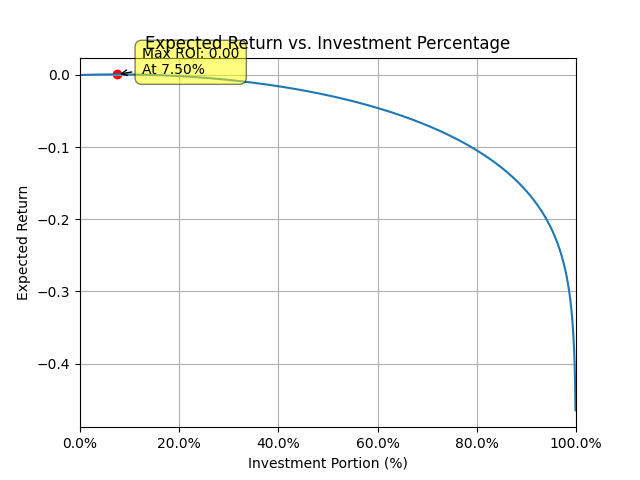

In [94]:
STATE_SIZE = 10
RETURNS = np.linspace(-1, 1, STATE_SIZE)
PROBABILITIES = np.random.dirichlet(np.ones(STATE_SIZE))


def RateOfReturn(probabilities, returns, fractions):
    assert np.isclose(probabilities.sum(), 1), "Probabilities must sum up to 1"
    assert probabilities.size == returns.size, "The size of probabilities and returns arrays must be the same"
    return np.sum(probabilities * np.log(1 + returns * fractions[:, np.newaxis]), axis=1)


expected_returns = RateOfReturn(PROBABILITIES, RETURNS, investment_fractions)
max_expected_return = np.max(expected_returns)
max_index = np.argmax(expected_returns)
optimal_investment_fraction = investment_fractions[max_index]  # Keep as decimal

print('Expectation is {:.4f}'.format(PROBABILITIES.dot(RETURNS)))
draw2dPlot(investment_fractions, expected_returns, optimal_investment_fraction, max_expected_return)

## Two Random Variables

To expand from one random variable (one investment world) to two random variables (two investments in the world), we would change the discrete probability function from $ p(r) $ to $ p(r_1, r_2) $, then meaning behind the notation is there is a probability for each return from investment 1 ($ r_1 $) and return for investment 2 ($ r_2 $).

The reason to not use $ p_1(r_1) * p_2(r_2) $ is because we also want to consider correlation between the two random variables.

The extended formula is also similar to the one random variable:

$ G(x, y) = \sum_{j=1}^{m_2} \sum_{i=1}^{m_1} p(r_i, r_j) \ln{(1 + r_i x + r_j y)} $

$ \frac{dG}{dx} = \sum_{j=1}^{m_2} \sum_{i=1}^{m_1} \frac{p(r_i, r_j)r_i}{1 + r_i x + r_j y} $

$ \frac{dG}{dy} = \sum_{j=1}^{m_2} \sum_{i=1}^{m_1} \frac{p(r_i, r_j)r_j}{1 + r_i x + r_j y} $

The $ G(x, y) $ is still concave because $ \ln(x) $ is concave and a positive weighted combination of that is also concave.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Expected return for investment 1: 0.03582888170510686
Expected return for investment 2: 0.08460449676412811


C:\Users\Mu Niu\AppData\Local\Temp\ipykernel_9056\2749439800.py:24: RuntimeWarning: divide by zero encountered in log
  values[i, j] = np.sum(P * np.log(1 + R[:, np.newaxis] * x + R * y))
C:\Users\Mu Niu\AppData\Local\Temp\ipykernel_9056\2749439800.py:24: RuntimeWarning: invalid value encountered in log
  values[i, j] = np.sum(P * np.log(1 + R[:, np.newaxis] * x + R * y))


Optimal fraction for investment 1: 0.135
Optimal fraction for investment 2: 0.385
Optimal log return is: 0.019079902580145428


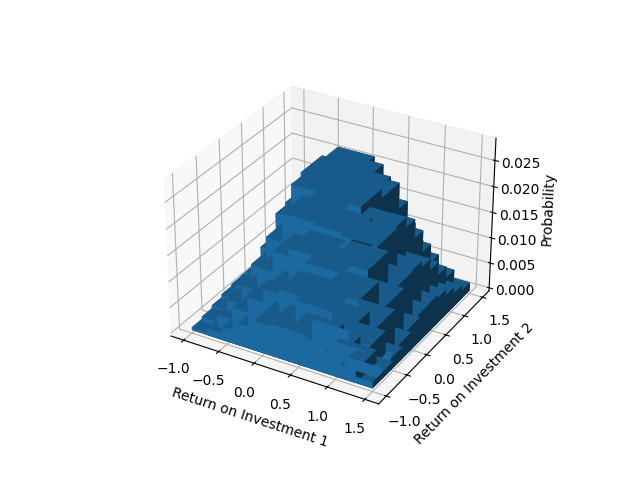

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


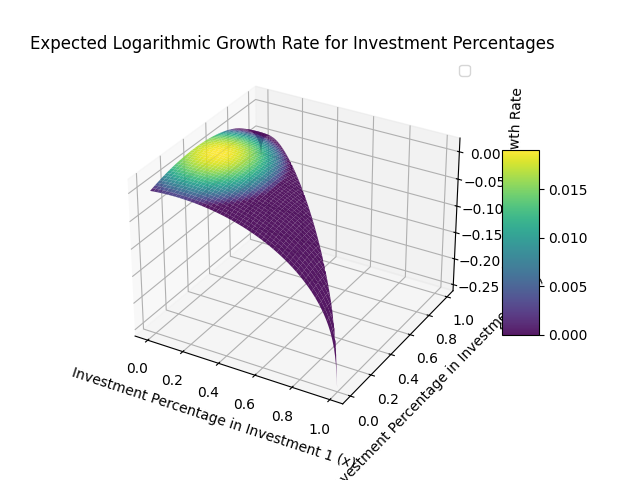

In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
from plot import *
from probability_generator import *

STATE_SIZE = 10
R = np.linspace(-1, 1, STATE_SIZE)
P = generate2dGaussian(R, means=np.asarray([0.05, 0.1]), sigmas=np.asarray([0.6, 0.5]))

print("Expected return for investment 1:", np.sum(P, axis=1).dot(R))
print("Expected return for investment 2:", np.sum(P, axis=0).dot(R))

# Define the grid for investment percentages
fraction_range = np.arange(0, 1, 0.005)  # Investment percentage for investment 1

values = np.zeros((fraction_range.size,) * P.ndim)  # Placeholder for the expected logarithmic growth rate

# Calculate the expected logarithmic growth rate for each combination of x and y
for i, x in enumerate(fraction_range):
    for j, y in enumerate(fraction_range):
        values[i, j] = np.sum(P * np.log(1 + R[:, np.newaxis] * x + R * y))

# Find the maximum value and index
max_index = np.nanargmax(values)  # This gives us the index in the flattened array
max_indices = np.unravel_index(max_index, values.shape)  # Convert to 2D indices
max_x = fraction_range[max_indices[0]]
max_y = fraction_range[max_indices[1]]
max_z = values[max_indices]
print("Optimal fraction for investment 1:", max_x)
print("Optimal fraction for investment 2:", max_y)
print("Optimal log return is:", max_z)

plt.close('all')
drawProbability(R, P)
draw3dPlot(fraction_range, fraction_range, values)

## Mathmatic Computation

Newton's Method

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Converged in 2 iterations.
[[0.         0.         0.        ]
 [0.13383382 0.38727697 0.01908048]
 [0.13352504 0.38672551 0.01908053]
 [0.13352492 0.3867253  0.01908053]]


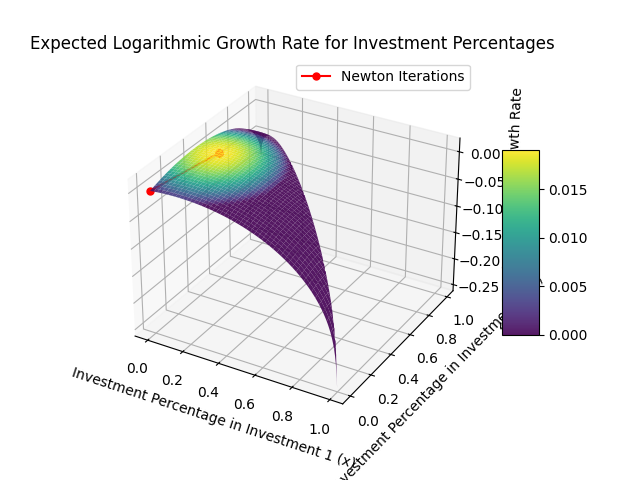

In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from newtons_method import newtonsIteration, newtonsMethod
from multivariate_kelly import kellyValue
from plot import draw3dPlot

X_points = newtonsMethod(R, P)
points = np.column_stack((np.array(X_points), np.array([kellyValue(R, P, point) for point in X_points])))
print(points)

draw3dPlot(fraction_range, fraction_range, values, points)

## Three random variables

This demo will able to show the investment return as color scaled scatter plot and also with Newton's method overlay.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Expected return for investment 1: -0.49000010634220853
Expected return for investment 2: -0.3092984437709006
Expected return for investment 3: 0.6163609715879118
Converged in 11 iterations.
[[0.         0.         0.         0.        ]
 [0.         0.         0.46357233 0.18835027]
 [0.         0.         0.54280214 0.20030189]
 [0.         0.         0.55907307 0.20182963]
 [0.         0.         0.56375139 0.202205  ]
 [0.         0.         0.56519    0.20231456]
 [0.         0.         0.56564093 0.20234832]
 [0.         0.         0.56578311 0.20235891]
 [0.         0.         0.56582802 0.20236225]
 [0.         0.         0.56584221 0.20236331]
 [0.         0.         0.5658467  0.20236364]
 [0.         0.         0.56584812 0.20236375]
 [0.         0.         0.56584857 0.20236378]]


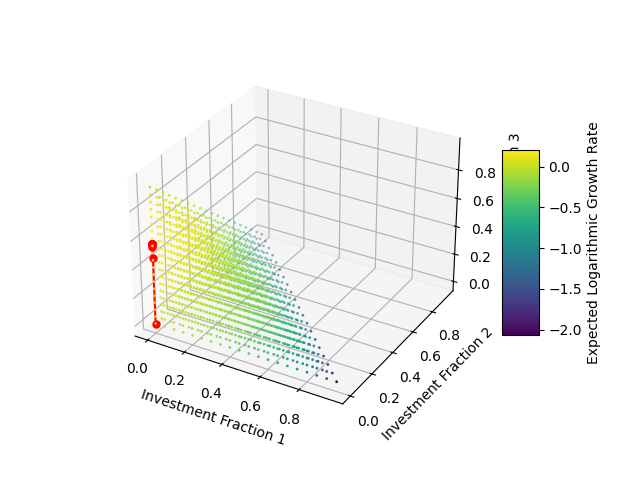

In [88]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from multivariate_kelly import kellyValue
from plot import draw3variablesPlot

DIMENSION = 3
STATE_SIZE = 2
R = np.linspace(-1, 1, STATE_SIZE)
P = np.random.dirichlet(np.ones(R.size ** DIMENSION)).reshape((R.size,) * DIMENSION)

print("Expected return for investment 1:", np.sum(P, axis=(1,2)).dot(R))
print("Expected return for investment 2:", np.sum(P, axis=(0,2)).dot(R))
print("Expected return for investment 3:", np.sum(P, axis=(0,1)).dot(R))

fraction_range = np.arange(0, 1, 0.05)
value = np.zeros((fraction_range.size,) * DIMENSION)  # Placeholder for the expected logarithmic growth rate
# Calculate the expected logarithmic growth rate for each combination of x and y
for i, x in enumerate(fraction_range):
    for j, y in enumerate(fraction_range):
        for k, z in enumerate(fraction_range):
            if x + y + z <= 1:  # Ensure the fractions sum to 1 or less
                value[i, j, k] = kellyValue(R, P, np.array([x, y, z]))

# Newton Solver
X_points = newtonsMethod(R, P)
points = np.column_stack((np.array(X_points), np.array([kellyValue(R, P, point) for point in X_points])))
print(points)

# print(value)

draw3variablesPlot(fraction_range, fraction_range, fraction_range, value, np.array(X_points))

## More random variables

A general formular for multivariate kelly criterion would be:

$ G(\vec{x}) = \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \ln{(1 + \vec{r}\cdot\vec{x})} $

$ \frac{dG}{dx_1} = \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \frac{r_{x_1}}{1 + \vec{r}\cdot\vec{x}} $

$ \frac{dG}{dx_2} = \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \frac{r_{x_2}}{1 + \vec{r}\cdot\vec{x}} $

$ \nabla G(\vec{x}) = \left[ \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \frac{r_{x_1}}{1 + \vec{r}\cdot\vec{x}}, ..., \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \frac{r_{x_n}}{1 + \vec{r}\cdot\vec{x}} \right] $ 

$ H_{G(\vec{x})_{ij}} = - \sum_{\vec{r}\in \vec{R}} p(\vec{r}) \frac{r_{x_i}r_{x_j}}{(1 + \vec{r}\cdot\vec{x})^2} $ 

Since it would be challenging to display the plot for more than 3 random variables, this section will only run a demo solver without plotting it.

In [85]:
%load_ext autoreload
%autoreload 2

import numpy as np
from newtons_method import newtonsMethod
from multivariate_kelly import kellyValue

R_RANGE = 8
DIMENSION = 8
R = np.linspace(-1, 1, R_RANGE)
P = np.random.dirichlet(np.ones(R.size ** DIMENSION)).reshape((R.size,) * DIMENSION)

X_points = newtonsMethod(R, P)
points = np.column_stack((np.array(X_points), np.array([kellyValue(R, P, point) for point in X_points])))
print(points)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Converged in 1 iterations.
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.89818256e-05 6.52280393e-04
  1.26289264e-04 0.00000000e+00 1.91325682e-04 4.62567728e-04
  1.49587011e-07]
 [0.00000000e+00 0.00000000e+00 7.89817570e-05 6.52281068e-04
  1.26289473e-04 0.00000000e+00 1.91325798e-04 4.62568148e-04
  1.49587011e-07]]


### Performance Benchmarking

|Dimention \ <br>Return Range|    1   |    2    |     3     |      4      |        5       |         6        |        7       |         8        |         9        |
|:--------------------------:|:------:|:-------:|:---------:|:-----------:|:--------------:|:----------------:|:--------------:|:----------------:|:----------------:|
|**2**                       | 2<br>0s|  4<br>0s|    8<br>0s|     16<br>0s|        32<br>0s|          64<br>0s|       128<br>0s|         256<br>0s|         512<br>0s|
|**3**                       | 3<br>0s|  9<br>0s|   27<br>0s|     81<br>0s|       243<br>0s|         729<br>0s|     2,187<br>0s|       6,561<br>0s|      19,683<br>0s|
|**4**                       | 4<br>0s| 16<br>0s|   64<br>0s|    256<br>0s|     1,024<br>0s|       4,096<br>0s|    16,384<br>0s|      65,536<br>1s|     262,144<br>4s|
|**5**                       | 5<br>0s| 25<br>0s|  125<br>0s|    625<br>0s|     3,125<br>0s|      15,625<br>0s|    78,125<br>1s|     390,625<br>4s|  1,953,125<br>28s|
|**6**                       | 6<br>0s| 36<br>0s|  216<br>0s|  1,296<br>0s|     7,776<br>0s|      46,656<br>1s|   279,936<br>3s|  1,679,616<br>17s|10,077,696<br>143s|
|**7**                       | 7<br>0s| 49<br>0s|  343<br>0s|  2,401<br>0s|    16,807<br>0s|     117,649<br>1s|   823,543<br>5s|  5,764,801<br>69s|
|**8**                       |        |         |           |             |    32,768<br>0s|     262,144<br>3s|2,097,152<br>27s|16,777,216<br>?s|
|**9**                       |        |         |           |             |    59,049<br>1s|     531,441<br>5s|                |                  |
|**10**                      |        |         |           |             |   100,000<br>1s|   1,000,000<br>9s|                |                  |
|**20**                      |20<br>0s|400<br>0s|8,000<br>0s|160,000<br>1s|3,200,000<br>25s|64,000,000<br>783s|                |                  |
